In [1]:
import sys
import os

sys.path.append(os.path.abspath("../..")) 

from utils.utils import min_max_scaling, \
    set_random_seeds, plot_images, get_top_k_confident_mistakes, \
    plot_top_mistakes, plot_training_results, plot_filters_and_feature_maps, count_params, get_gpu
from models.AlexNet import AlexNet
from models.VGG import VGG, get_vgg_features
from engine.DatasetProvider import DatasetProvider, DatasetName
from engine.Trainer import Trainer
from models.AlexNet import AlexNet
import torchvision
from torchvision.transforms import transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler
import torch
from torch import nn
import torch.utils.data as data
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
set_random_seeds(42)

### Data Loading

In the original paper, researcers used the following tecniques:

**1. Training: Multi-Scale Jittering**

Since VGG requires a fixed input size of **224 × 224**, the authors used a **two-stage Scale Jittering** strategy to handle variable image resolutions and significantly improve model robustness.

Stage 1 — S = 256 (Global Context)
- The image is resized such that **its smallest side equals 256 pixels**.
- A random **224 × 224** crop is then extracted from this resized image.
- At this scale, the crop covers **most of the image content**.
- Purpose: The network learns **global structures** and fundamental low-level features (edges, textures, basic object layout).

Stage 2 — S = 384 (Fine-Grained Detail)
- The model is initialized with weights obtained from **Stage 1** (to accelerate convergence).
- The image is resized so that **its smallest side equals 384 pixels**.
- A random **224 × 224** crop is extracted → this now corresponds to a **zoomed-in** partial view of the object/scene.
- Purpose: Forces the network to learn **complex, highly discriminative local patterns** inside objects.

During SGD training, each image is seen through many different random crops → this strong **data augmentation** acts as a very effective regularizer against overfitting.

**2. Evaluation: Inference Techniques**

To maximize test accuracy, the authors avoided naive single-crop resizing and instead employed two powerful inference strategies:

A. Dense Evaluation (Fully Convolutional)
- The fully connected (FC) layers at the end of the network are replaced with equivalent **convolutional layers**:
  - Last FC layer → **7 × 7** conv
  - Final FC layer → **1 × 1** conv
- This transforms the network into a **fully convolutional network (FCN)**.
- Benefit: The model can now accept **arbitrarily sized inputs** (no fixed 224 × 224 requirement).
- Inference process:
  1. Resize the image so its **shortest side = Q** (commonly Q = 384 or 512).
  2. Feed the full image through the network.
  3. Obtain a **spatial class score map** instead of a single vector.
  4. **Spatially average** the score map → produce the final class probabilities.

B. Multi-Crop Evaluation
- The test image is resized to a fixed scale (shortest side usually 256 or 384).
- Multiple **224 × 224** crops are extracted from this resized image.
- Classic setting (10-crop ensemble):
  - Center crop
  - Four corner crops
  - Horizontal flips of all five crops above
- Each crop is passed independently through the network.
- Final prediction = **average of the softmax probabilities** across all 10 crops.

This combination of **dense evaluation** and **multi-crop averaging** was crucial for achieving state-of-the-art results with the VGG architectures.

However, this all stuff is assumed for the big images, like in ImageNet. Since we are using CIFAR10, we will resize images from 32 to 256, and crop them to 224.

In [3]:
dataset = DatasetProvider(
    dataset_name=DatasetName.CIFAR,
    batch_size=32,
    resize=256,
    random_rotation_degrees=5,
    random_hor_flip_probability=0.5,
    random_crop_size=224,
    pretrained_means=[0.485, 0.456, 0.406],
    pretrained_stds=[0.229, 0.224, 0.225],
)

Also above i have used pretrained params which were used in original VGG(details explained later)

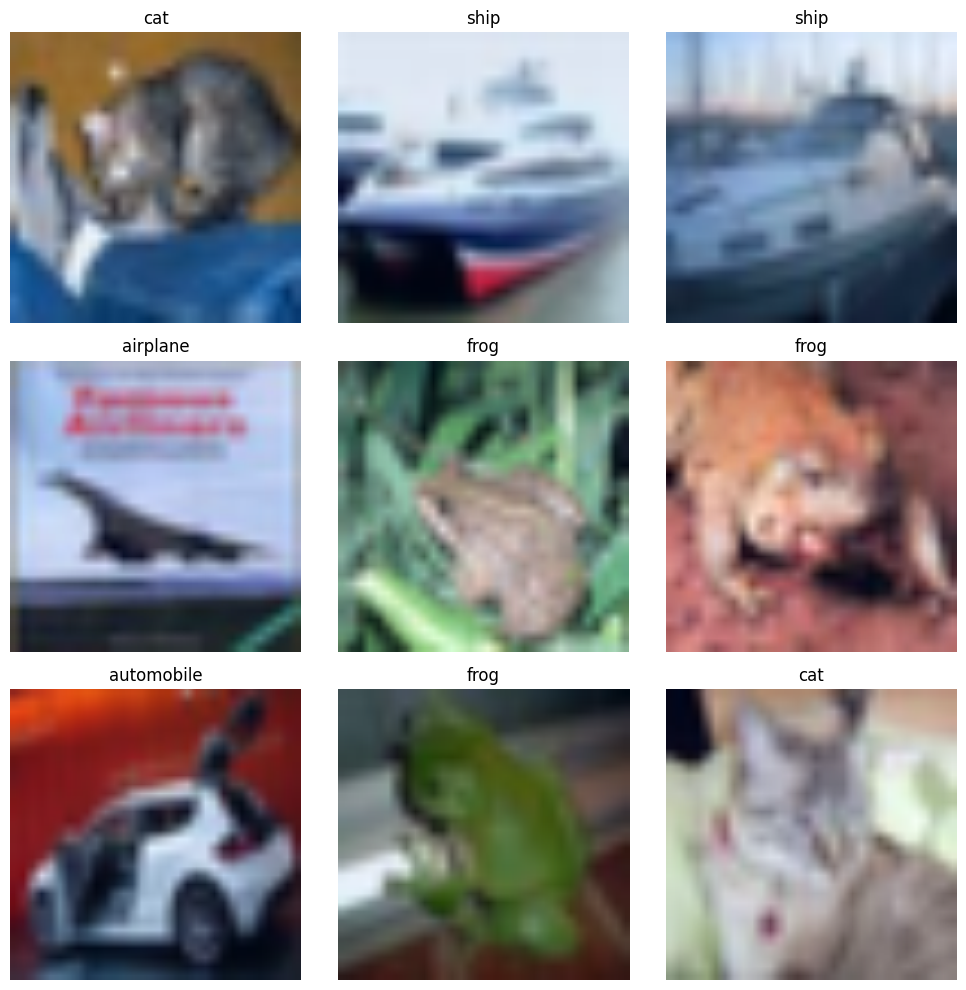

In [4]:
images, labels = next(iter(dataset.testloader))
classes = dataset.classes

plot_images(images[:9], labels[:9], classes, normalize=True)

### Architecture

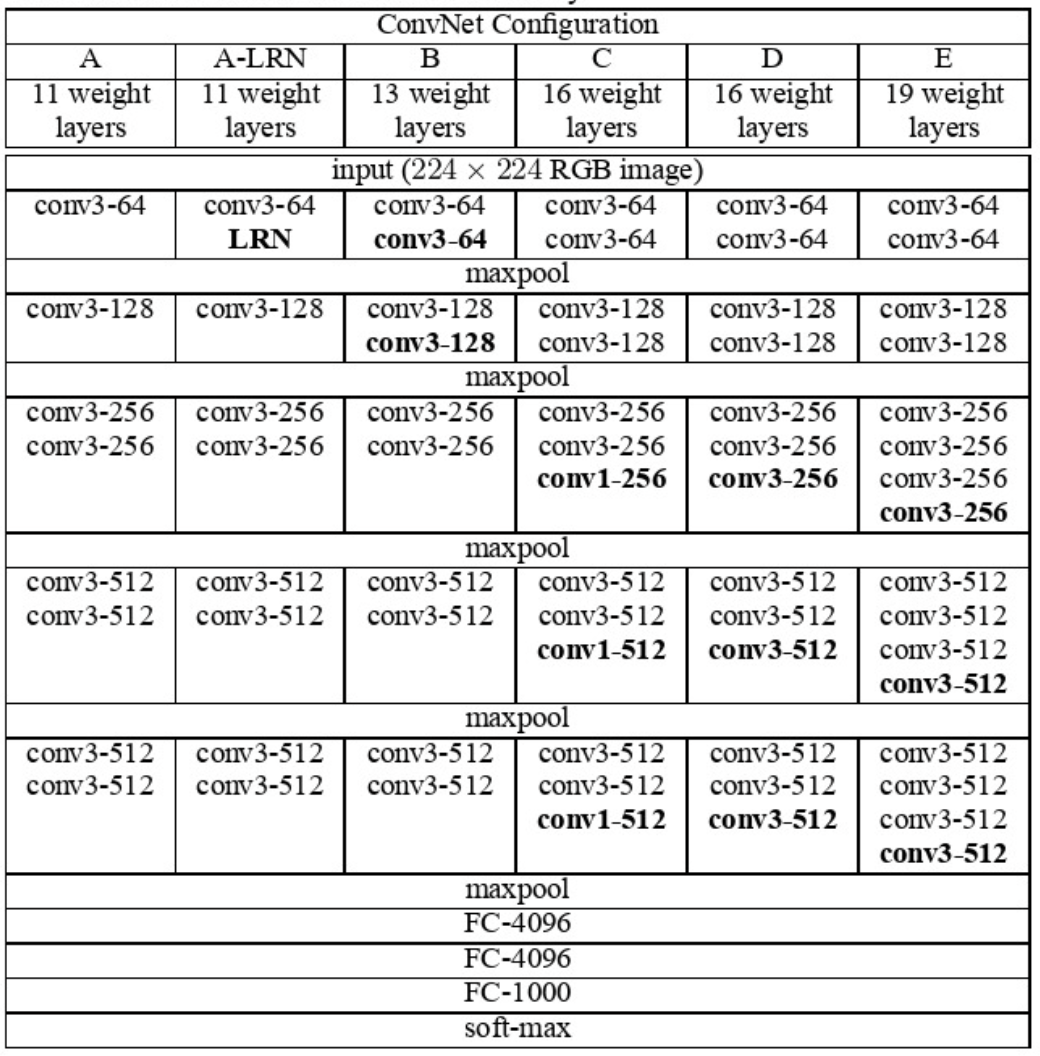

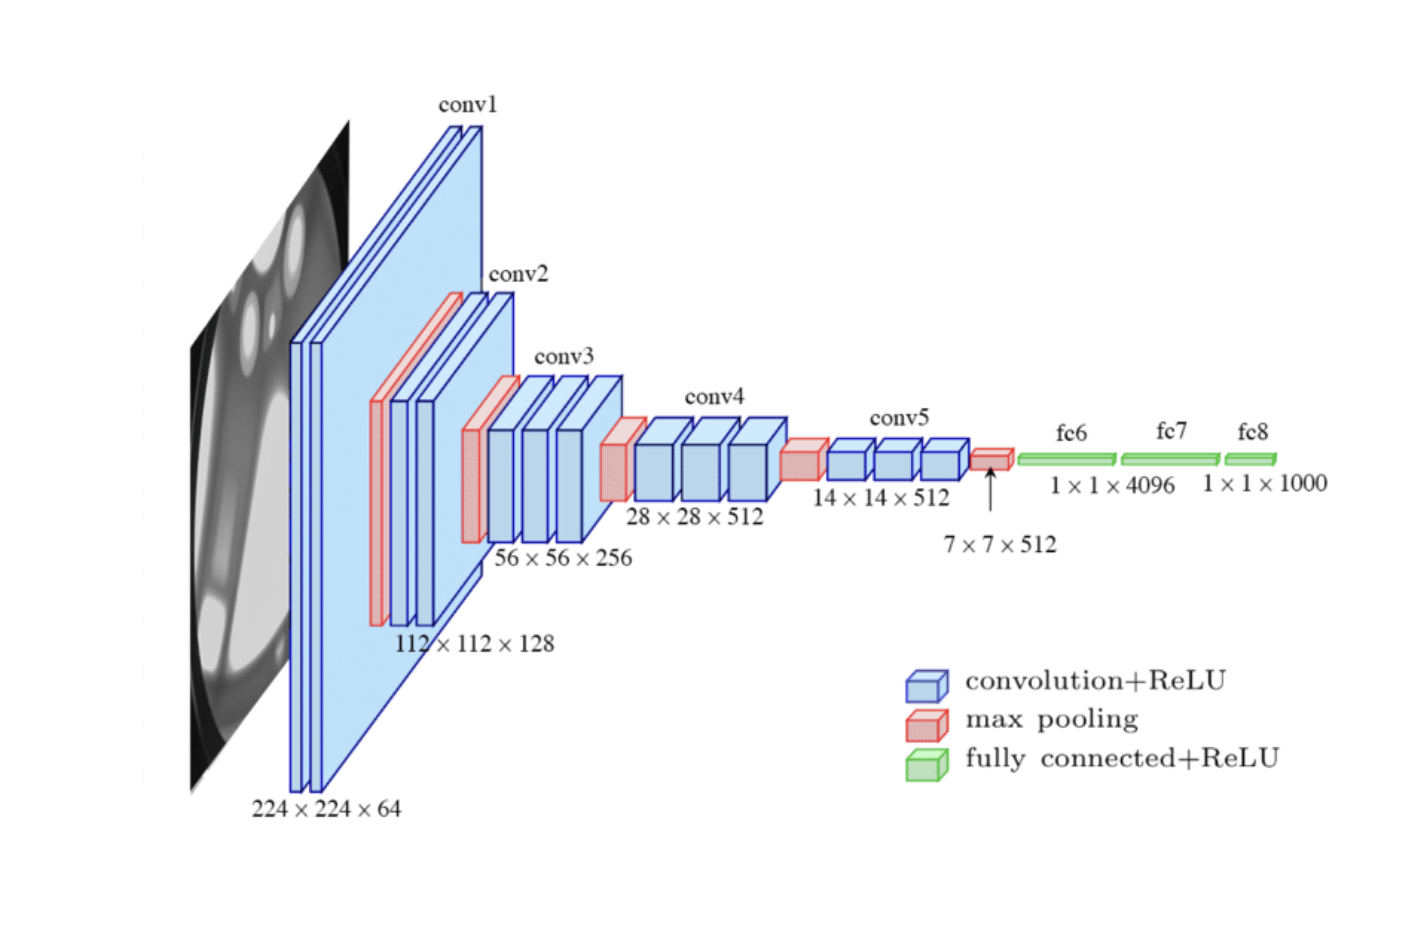

Next thing that i want to show to you is the one of the main changes. And i am talking about using conv layers with kernel size 3 x 3, and not just one conv layer, but stack of them! To understand the reasons behind it - lets just look at the example of using one conv layer with kernel size 7 x 7, and three conv layers with kernel size 3 x 3

In [5]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7, stride=1)
conv_stack = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1),
)

conv_n_weights = torch.numel(conv.weight.data)

conv_stack_n_weights = 0
for m in conv_stack.modules():
    if isinstance(m, torch.nn.Conv2d):
        conv_stack_n_weights += torch.numel(m.weight.data)

print(f"Number of weights in conv: {conv_n_weights}")
print(f"Number of weights in conv stack: {conv_stack_n_weights}")

reduction = (1 - (27/49)) * 100
print(f"Weight reduction: {reduction:.2f}%")

def calculate_receptive_field(layers_kernels):
    """
    Formula: RF_out = RF_in + (kernel_size - 1) * cumulative_stride
    Assuming stride=1 for all
    """
    rf = 1
    for k in layers_kernels:
        rf += (k - 1)
    return rf

rf_single = calculate_receptive_field([7])
rf_stack = calculate_receptive_field([3, 3, 3])

print(f"Receptive Field (7x7): {rf_single}x{rf_single}")
print(f"Receptive Field (3x3x3): {rf_stack}x{rf_stack}")

class NonLinearityBenefit(nn.Module):
    def __init__(self):
        super().__init__()
        self.single_layer_relu = nn.Sequential(
            nn.Conv2d(1, 1, 7),
            nn.ReLU() 
        )
        
        self.stack_layer_relu = nn.Sequential(
            nn.Conv2d(1, 1, 3),
            nn.ReLU(), # 
            nn.Conv2d(1, 1, 3),
            nn.ReLU(), 
            nn.Conv2d(1, 1, 3),
            nn.ReLU()  
        )

print("\n--- Decision Boundaries ---")
print(f"Single 7x7: 1 ReLU layer")
print(f"Stack 3x3: 3 ReLU layers (More discriminative power!)")

Number of weights in conv: 49
Number of weights in conv stack: 27
Weight reduction: 44.90%
Receptive Field (7x7): 7x7
Receptive Field (3x3x3): 7x7

--- Decision Boundaries ---
Single 7x7: 1 ReLU layer
Stack 3x3: 3 ReLU layers (More discriminative power!)


By stacking three  layers instead of using one  layer, we achieve:

* **Identical Receptive Field:** Both methods "see" a  area of the input image, so no spatial information is lost.
* **45% Fewer Parameters:** We reduce the weight count from 49 to 27 per channel, making the model lighter and faster to train.
* **Triple the Non-Linearity:** We get three ReLU activations instead of one. This deeper "decision-making" allows the network to learn much more complex features.

Essentially, VGG proves that **going deeper with smaller filters is more efficient and powerful** than going wider with large ones.

### Pretrained model

Actually, i have tried to train model from sctach on CIFAR10 and understand that my laptop will not thank me for this(Google Colab hadn't allowed me to train such big model in thier GPU's). So, we will be using pretrained model

In [6]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained=True)

pretrained_model

/Users/nickol/miniforge3/envs/ml-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nickol/miniforge3/envs/ml-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [7]:
pretrained_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [8]:
pretrained_model.avgpool

AdaptiveAvgPool2d(output_size=(7, 7))

In [9]:
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [10]:
count_params(pretrained_model)

Layer Name                               | weight       | bias         | Total     
-----------------------------------------------------------------------------------
features.0 (Conv2d)                      | 1728         | 64           | 1792      
features.4 (Conv2d)                      | 73728        | 128          | 73856     
features.8 (Conv2d)                      | 294912       | 256          | 295168    
features.11 (Conv2d)                     | 589824       | 256          | 590080    
features.15 (Conv2d)                     | 1179648      | 512          | 1180160   
features.18 (Conv2d)                     | 2359296      | 512          | 2359808   
features.22 (Conv2d)                     | 2359296      | 512          | 2359808   
features.25 (Conv2d)                     | 2359296      | 512          | 2359808   
classifier.0 (Linear)                    | 102760448    | 4096         | 102764544 
classifier.3 (Linear)                    | 16777216     | 4096         | 167

Huge number of params......Lets comapare with AlexNet

In [11]:
model = AlexNet(3, 10)
count_params(model)

Layer Name                               | weight       | bias         | Total     
-----------------------------------------------------------------------------------
net.conv1 (Conv2d)                       | 34848        | 96           | 34944     
net.conv2 (Conv2d)                       | 614400       | 256          | 614656    
net.conv3 (Conv2d)                       | 884736       | 384          | 885120    
net.conv4 (Conv2d)                       | 1327104      | 384          | 1327488   
net.conv5 (Conv2d)                       | 884736       | 256          | 884992    
net.fc1 (Linear)                         | 37748736     | 4096         | 37752832  
net.fc2 (Linear)                         | 16777216     | 4096         | 16781312  
net.fc3 (Linear)                         | 40960        | 10           | 40970     
-----------------------------------------------------------------------------------
TOTAL                                    |                              | 58

### Fine-tuning

So, what i have done? How to use this pretrained model? We see that pretrained model cosnsists of three parts:
- **self.features** - this is where we extract our features with the help of convolutions, and it consists of multiple VGG blocks which we can define like in the code below, here we use new layer - BatchNorm and about it i will tell in the next paper implementations in a more details, for now you can interpret it as this thing normalizes the data coming through layers.
- **self.avgpool** - when i was reading the paper i also couldn't understand why need it? Thr truth is that this allows to use images with spatial resolution $S > 224$ without resizing. The magic is that the next block, classifier, expects that from features come batch_size x 512 x 7 x 7 tensor, but if the initial image was bigger - the spatia; resolution can also be bigger than 7 x 7 , so we can strictly reduce it to the specified size.
- **self.classifier** - after we extract features, and every image is represented with veryy high dimensional vector, we can learn patterns with the help of the three fully connected layers, also here we use dropout in order to prevent overfitting and add some random noise which forces the model to learn harder patters. 

In [12]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

In [13]:
class VGG_example(nn.Module):
    def __init__(self, in_channels, out_features, config, batch_norm=True):
        super().__init__()

        self.features = get_vgg_features(config, in_channels, batch_norm)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, out_features)
        )

        self._initialize_weights()

    def forward(self, X):
        feat = self.avgpool(self.features(X))
        flat_feat = torch.flatten(feat, 1)
        y_hat = self.classifier(flat_feat)
        return (y_hat, flat_feat)

Below this is a function that helps us to create features block using config

In [14]:
def get_vgg_features(config, in_channels, batch_norm=False):
    features = []
    curr_in_channels = in_channels

    for param in config:
        if isinstance(param, int):
            features.append(nn.Conv2d(
                in_channels=curr_in_channels, out_channels=param, kernel_size=3, stride=1, padding=1
            ))

            if batch_norm:
                features.append(nn.BatchNorm2d(param, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))

            features.append(nn.ReLU(inplace=True))

            curr_in_channels = param
        else:
            features.append(nn.MaxPool2d(kernel_size=2, stride=2))

    return nn.Sequential(*features)

In [15]:
get_vgg_features(config=vgg11_config, in_channels=3, batch_norm=True)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

Let's try to use weights from pretrained model to our

But we have only one remaining problem

In [16]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

We do not need out_features = 1000, we need 10 since CIFAR10 contain 10 classes, so we need to replace that layer

In [17]:
in_features = pretrained_model.classifier[-1].in_features
fc_final = nn.Linear(in_features=in_features, out_features=10)

fc_final

Linear(in_features=4096, out_features=10, bias=True)

In [18]:
pretrained_model.classifier[-1] = fc_final
pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [19]:
model = VGG(in_channels=3, out_features=10, config=vgg11_config, batch_norm=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Models are indentic

In [20]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

### Training

In [21]:
trainer = Trainer(
    model=model,
    dataset=dataset,
    loss_name="cross_entropy",
    optimizer_name="SGD",
    optmizer_params={
        "momentum": 0.9,
        "weight_decay": 0.0005,
    },
    lerarning_schedule_params={
        "mode": "min",
        "factor": 0.1,
        "patience": 5,
    },
    lr=0.01,
    device=get_gpu(),
    accumulation_steps=8
)


╭─ Experiment Config ─╮
│ Starting Training   │
│ Model: VGG          │
│ Dataset: cifar10    │
│ Device: mps         │
╰─────────────────────╯

In [22]:
y_hat, y_true, val_err, probs = trainer.make_predictions()

val_err

0.9048

In [23]:
trainer.train(max_epochs=5)


Output()

✔ Training Complete!

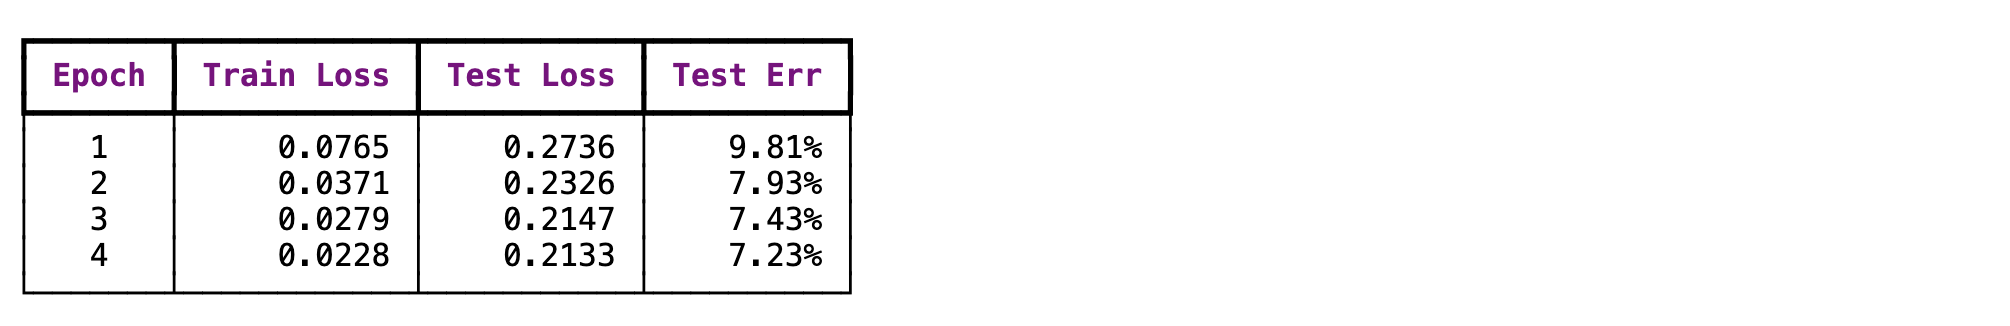

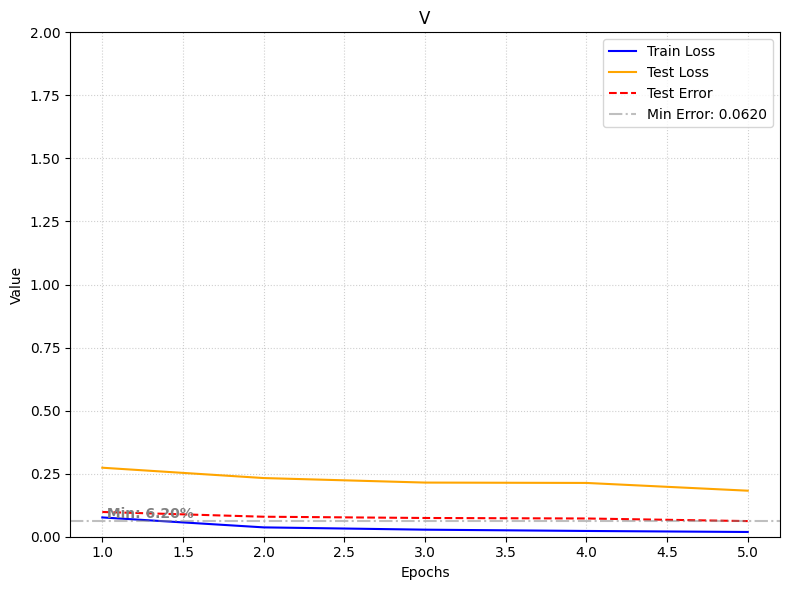

In [25]:
history = trainer.history

plot_training_results(history, titles="VGG-11 traning ob CIFAR10")

It was quiet long... but we have results, and they are not bad. After 1 epoch, validation error dropped from ~90% to ~10%.

### Testing

In [26]:
y_hat, y_true, val_err, probs = trainer.make_predictions()

val_err

0.06769999999999998

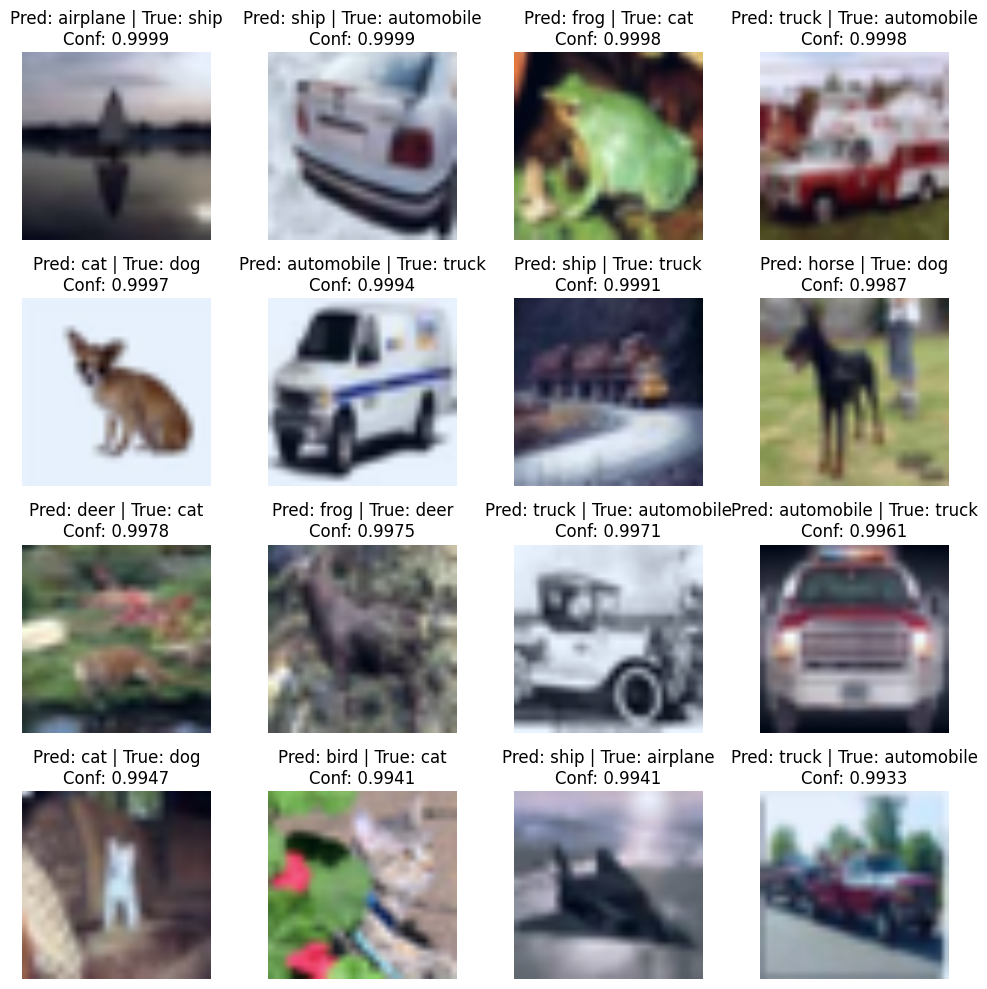

In [29]:
mistakes = get_top_k_confident_mistakes(y_hat, y_true, probs, k=16)

plot_top_mistakes(mistakes, classes, trainer)

Here we see that the biggest mistakes of the network are justified, and even for human hard to correctly classify some of these images